In [1]:
import pandas as pd
import numpy as np
import os.path as op
import unicodedata
import sys
from gensim.models import FastText
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedShuffleSplit, train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report, make_scorer

basename = "/home/adrian/PhD/Tweet-Classification-Diabetes-Distress"
path_utils = op.join(basename , "utils")
sys.path.insert(0, path_utils)

from sys_utils import load_library
from tweet_utils import *

from preprocess import Preprocess
prep = Preprocess()

model_we = FastText.load("/home/adrian/PhD/Data/FastText_embedding_20190703/ft_wordembeddings_dim300_minCount5_URL-User-toConstant_iter10_20190703")

trainingData = pd.read_csv(op.join(basename, "data", "ManualLabel_TypeDiabetes_Sexe.csv"), usecols=["text", "user_description", "user_name", "user_screen_name", "HasDiabetes", 
                            "Type_Diabetes", "Sexe", "History_HasDiab", "History_TypeDiab", "History_Sex"],
                           #converters={'user_description': lambda x: tt(x)}
                           #converters={'HasDiabetes': lambda x: int(x, 16)}
                          #dtype={'Type_Diabetes':np.int32}
                          )


print(trainingData.dtypes)
trainingData.head(5)

[nltk_data] Downloading package punkt to /home/adrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/adrian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/adrian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


text                 object
user_description     object
user_name            object
user_screen_name     object
HasDiabetes         float64
Type_Diabetes         int64
Sexe                 object
History_HasDiab      object
History_TypeDiab    float64
History_Sex          object
dtype: object


,text,user_description,user_name,user_screen_name,HasDiabetes,Type_Diabetes,Sexe,History_HasDiab,History_TypeDiab,History_Sex
0,@Dmartelz24 @Dterrazas760 Then diabetes Kankle...,Account Manager for Dr.Pepper Snapple Group. D...,Jimmy Martinez,R8TERFAN1,0.0,0,M,NaN,NaN,NaN
1,"Woke up with a 30 blood sugar, hate half a can...",It's worth it.,Kelsey Smith,Kelsey_Smith88,1.0,1,U,NaN,NaN,M
2,I’m going back to my roots. I’m trying shakes ...,Life isn't about surviving the storms...it's a...,Lennie Ledesma,lennieledesma,1.0,0,U,NaN,NaN,M
3,Praying I don’t get diabetes,I'm still not fat I'm just short for my weight...,Regina George 💎,BlowindatPINK_,0.0,0,F,NaN,NaN,NaN
4,Happy world diabetes today💙💙 #t1dstrong https:...,I have a dead pancreas☹️ santiago🐬,riley:),itsRiMay,1.0,1,F,NaN,NaN,NaN


In [2]:
def preprocess_tweet(tweet):
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="replace", mode_Mentions="replace")
    tweet = prep.tokenize(tweet)
    return tweet


def create_history_typeDiabetes_column(row):
    #print(row)
    if row["History_TypeDiab"] == 0: return 0
    elif row["History_TypeDiab"] == 1: return 1
    elif row["History_TypeDiab"] == 2: return 2
    elif pd.isnull(row["History_TypeDiab"]): return row["Type_Diabetes"]
    else: print("ERROR: Should not occur:  ", row["Type_Diabetes"], ";;;", row["Type_Diabetes"])

trainingData['history_typeDiab_total'] = trainingData.apply (lambda row: create_history_typeDiabetes_column(row), axis=1)

#typeDiab = trainingData.Type_Diabetes
#history_typeDiab = trainingData.History_TypeDiab
#trainingData[["Type_Diabetes", "History_TypeDiab", "history_typeDiab_total"]].head(50)

In [3]:
#label = "Type_Diabetes"
label = "history_typeDiab_total"
data_pd = trainingData[["text", "user_description", "user_name", label]]
data_pd.head()

data_pd.text = data_pd.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model_we))
data_pd.user_description = data_pd.user_description.map(lambda userDesc: np.zeros((model_we.vector_size, )) 
                                                if isinstance(userDesc, float) or userDesc == " " 
                                                else tweet_vectorizer(preprocess_tweet(userDesc), model_we))

#def userName_to_vec(name):
#    #print("name:", name)
#    try:
#        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
#        vec = model_we[firstName]
#    except:
#        vec = np.zeros((200, ))

#    return vec

#def TEMP_userName_to_vec(name):
    #print("name:", name)
#    try:
#        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
#        vec = model_we[firstName]
#        return 1
#    except:
#        #vec = np.zeros((200, ))
#        return 0


#data_pd.user_name = data_pd.user_name.map(lambda name: userName_to_vec(name))
#data_pd[label] = data_pd[label].map(labelEncode)


# remove the tweets that are empty because there is no word embedding
data_pd = data_pd[data_pd["text"].apply(lambda x: len(x)>0) ]
print(data_pd.shape)

#data_pd.user_name = data_pd.user_name.map(lambda tweet: prep.remove_non_ascii(tweet))
data_pd.head(10)


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for Ω !!!!!!!!!!!!
no embedding for Ω !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for 𝙸 !!!!!!!!!!!!
no embedding for 𝚊 !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for ♏ !!!!!!!!!!!!
no embedding for ☉ !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embed

,text,user_description,user_name,history_typeDiab_total
0,"[0.13586353, 0.027363993, 0.06921981, -0.12088...","[0.18690765, 0.13809207, 0.1828839, -0.0421094...",Jimmy Martinez,0
1,"[0.1462359, -0.016409125, 0.09445919, -0.13824...","[0.13541272, 0.21099865, 0.045411382, -0.10143...",Kelsey Smith,1
2,"[0.21270822, 0.12710376, 0.005462071, -0.14057...","[0.19743742, 0.11713521, 0.05193192, -0.145208...",Lennie Ledesma,0
3,"[0.14139095, 0.020625114, -0.045841414, -0.129...","[0.12040155, 0.17090678, -0.009378558, -0.0366...",Regina George 💎,0
4,"[0.18577905, 0.10092051, 0.15427631, -0.224091...","[0.13634622, 0.16270036, 0.075934134, -0.15971...",riley:),1
5,"[0.096696705, 0.16255002, 0.025634775, -0.0991...","[0.19471228, -0.025450045, 0.15585724, -0.1077...",Joel Sutcliffe,0
6,"[0.09403044, 0.11345235, -0.047778692, -0.1426...","[0.13523303, 0.080672234, 0.021718618, -0.0020...",Neptune,0
7,"[0.15010017, 0.09872513, 0.024493663, -0.10378...","[0.22910456, 0.052996382, 0.04109762, -0.10783...",J.T. Nutt,0
8,"[0.10010086, 0.15650599, 0.12639698, -0.135969...","[-0.06283407, 0.017540433, 0.100164525, -0.103...",carolion,0
9,"[0.13212484, 0.072526835, 0.044010554, -0.1727...","[0.007866707, 0.13318682, 0.06544415, -0.09305...",Aubs 💖🧜🏽‍♀️,0


In [4]:
class ItemSelect(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return np.asarray(data[self.key].values.tolist())

In [19]:
# choose algo:
#---------------------------------------------------------------------------
modelAlgo = "SVC"

if modelAlgo == "MultinomialNB":
    model = MultinomialNB(random_state=0)
elif modelAlgo == "SVC":
    model = SVC(random_state=0)
elif modelAlgo == "logReg":
    model = LogisticRegression(random_state=0)
elif modelAlgo == "RandomForest" :
    model = RandomForestClassifier(random_state=0)
elif modelAlgo == "XGBoost" :
    model = XGBClassifier(random_state=0)
elif modelAlgo == "MLP" :
    model = MLPClassifier(early_stopping=True, batch_size=32, random_state=0)

from imblearn.pipeline import Pipeline    
    
pipeline  = Pipeline([
                #("debuge", Debug("start")),
                ('union', FeatureUnion(
                            transformer_list = [
                                ('tweet', Pipeline([
                                    ('tweetsSelector', ItemSelect(key='text')),
                                    #("debugeq", Debug("text Selector")),
                                ])),  
                                ('userDesc', Pipeline([
                                    ('userDescSelector', ItemSelect(key='user_description'))
                                ])),
#                                ('userName', Pipeline([
#                                    ('userNameSelector', ItemSelect(key='user_name'))
#                                ]))     
                            ],
                )),
                #("debuggg", Debug("before model")),
                ('smote', SMOTE(random_state=12, sampling_strategy="auto", n_jobs=-1)), # , ratio = 1.0
                ('model', model),
                #("debuggg", Debug("after model")),
            ])


# parameter grid for grid search by using fastText embeddings
parameters = {
                'union__transformer_weights' : #[#{"tweet": 1, "userDesc":1, "userName":1},
#                                                {"tweet": 1, "userDesc":1, "userName":0.8}, 
#                                                {"tweet": 1, "userDesc":1, "userName":0.5},
#                                                {"tweet": 1, "userDesc":1, "userName":0.5},
#                                                {"tweet": 1, "userDesc":1, "userName":0.4},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.4},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.6},
#                                                {"tweet": 1, "userDesc":0.7, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0.9, "userName":0.5},
#                                                ],
                                               [#{"tweet": 1, "userDesc":1}, 
#                                                {"tweet": 1, "userDesc":0.7}, 
                                                {"tweet": 1, "userDesc":0.5},
#                                                {"tweet": 1, "userDesc":0.3},
#                                                {"tweet": 1, "userDesc":0.1},
#                                                {"tweet": 1, "userDesc":0.0},
#                                                {"tweet": 0, "userDesc":1}
                                                ],
    
               'smote__k_neighbors' : [3],
#               # param for SVC
               'model__kernel' : ["linear"],#["linear", "poly", "rbf"],
               'model__C' : [1.0, 0.5, 0.1],
               'model__tol' : [1e-1, 1e-2],
#               'model__class_weight' : ["balanced", {0:1, 1:1, 2:1}, {0:1, 1:2, 2:1}, {0:1, 1:1, 2:2}, {0:1, 1:2, 2:2}],
#
#               # param for RandomForestClassifier
#               'model__n_estimators' : [50, 100, 150],
#               'model__criterion' : ['gini', 'entropy'],
#               'model__max_features' : ['auto', 'log2'],
#               'model__max_depth' : [ 5, 10, 20, 30]
#
#               # param for XGBoost Best: 0.910828 using {'model__learning_rate': 0.05, 'model__reg_alpha': 0, 'model__max_depth': 3, 'model__reg_lambda': 1.5, 'model__n_estimators': 300}
#               'model__max_depth' : [3,4],
#               'model__learning_rate' : [0.5, 0.1, 0.05],#, 0.01, 0.001],
#               'model__booster' : ["gblinear"], #["gbtree", "gblinear", "dart"],
#               'model__gamma' : [0, 0.01],
#               'model__n_estimators' : [80, 100, 150],
#               'model__reg_alpha' : [0, 0.1],
#               'model__reg_lambda' : [0.5, 1.0]
}


In [20]:

def label_encode(sex):
    # no type 0, type 1 = 1, type 2 = 2
    if sex == 0: return(-1) 
    else: return(1)
    
    
print("data before filter out gestational diabetes:", data_pd.shape, type(data_pd))
data_pd_withoutGestational = data_pd.loc[data_pd[label] != 3]

#data_pd_withoutGestational = data_pd_withoutGestational.loc[data_pd[label] != 0]

#print("data after before filter out gestational diabetes:", data_pd_withoutGestational.shape, type(data_pd_withoutGestational))
X = data_pd_withoutGestational[["text", "user_description"]]
y = data_pd_withoutGestational[label]
#X = data_pd[["text", "user_description"]]
#y = data_pd[label]#.map(label_encode)
#y = data_pd_withoutGestational[label]#.map(label_encode)


#temp = data_pd.loc[data_pd[label] != 2]
#print("Temp:", temp.shape, type(temp))
#X = temp[["text", "user_description"]]
#y = temp[label].map(label_encode)
print("X :", X.shape, type(X))
print("y.unique: ", y.unique())
print(y.value_counts())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

    # Over sample traininig set
    #sm = SMOTE(random_state=12, ratio = 1.0, n_jobs=-1)
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
#    ros = RandomOverSampler(random_state=0)
#    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
#    print("X_train_res:", X_train_res.shape, type(X_train_res))

#    X_train_pd = pd.DataFrame(X_train_res, columns=["text", "user_description", "user_name"])
#    X_test_pd = pd.DataFrame(X_test, columns=["text", "user_description", "user_name"])
X_train_pd = pd.DataFrame(X_train, columns=["text", "user_description"])
X_test_pd = pd.DataFrame(X_test, columns=["text", "user_description"])

#from sklearn.metrics import precision_score, roc_auc_score, make_scorer
prec_scorer = make_scorer(precision_score, average="micro")
print("Start Grid search...")
grid = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-2, verbose=2, scoring=prec_scorer)
grid.fit(X_train_pd, y_train)
print("\nBest: %f using %s" % (grid.best_score_, grid.best_params_))

    #grid.best_estimator_#.fit(X_train_res, y_train_res)
y_pred = grid.best_estimator_.predict(X_test_pd)
#print("F1-Score:", f1_score(y_test, y_pred))
#print("Precision: ",precision_score(y_test, y_pred))
#print("Recall: ", recall_score(y_test, y_pred))    
print("Accuracy: ", accuracy_score(y_test, y_pred))   
print("Performance overall: ")
print(classification_report(y_test, y_pred))





data before filter out gestational diabetes: (1897, 4) <class 'pandas.core.frame.DataFrame'>
X : (1889, 2) <class 'pandas.core.frame.DataFrame'>
y.unique:  [0 1 2]
0    825
2    539
1    525
Name: history_typeDiab_total, dtype: int64
Start Grid search...
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  35 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-2)]: Done  60 out of  60 | elapsed:   47.2s finished



Best: 0.736006 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 3, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.5}}
Accuracy:  0.7407407407407407
Performance overall: 
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       243
           1       0.74      0.72      0.73       157
           2       0.72      0.75      0.74       167

    accuracy                           0.74       567
   macro avg       0.74      0.74      0.74       567
weighted avg       0.74      0.74      0.74       567



In [ ]:
# SVC - SMOTE - precision scoring
 

# Take this one

# SVC - no SMOTE
#Best: 0.733737 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.1, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.5}}
#Accuracy:  0.7530864197530864
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.71      0.87      0.78       243
#           1       0.83      0.69      0.75       157
#           2       0.78      0.64      0.70       167

#   micro avg       0.75      0.75      0.75       567
#   macro avg       0.77      0.73      0.75       567
#weighted avg       0.76      0.75      0.75       567


# SVC - SMOTE
#Best: 0.739032 using {'model__C': 0.5, 'model__kernel': 'linear', 'model__tol': 0.01, 'smote__k_neighbors': 3, 'union__transformer_weights': {'tweet': 1, 'userDesc': 0.3}}
#Accuracy:  0.7372134038800705
#Performance overall: 
#              precision    recall  f1-score   support

#           0       0.74      0.78      0.76       243
#           1       0.72      0.69      0.71       157
#           2       0.75      0.72      0.73       167

#   micro avg       0.74      0.74      0.74       567
#   macro avg       0.74      0.73      0.73       567
#weighted avg       0.74      0.74      0.74       567


In [15]:
from sklearn.externals import joblib
joblib.dump(grid.best_estimator_, 'bestModel_typeDiabetes_20190709.model', compress = 1)

/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['bestModel_typeDiabetes_20190709.model']

Classes before: ['Unknown' 'Type 1' 'Type 2']
unique labels: [0 1 2]
Classes: ['Unknown' 'Type 1' 'Type 2']
Confusion matrix, without normalization
[[181  28  34]
 [ 29 113  15]
 [ 29  12 126]]
Classes before: ['Unknown' 'Type 1' 'Type 2']
unique labels: [0 1 2]
Classes: ['Unknown' 'Type 1' 'Type 2']
Normalized confusion matrix
[[0.74 0.12 0.14]
 [0.18 0.72 0.1 ]
 [0.17 0.07 0.75]]


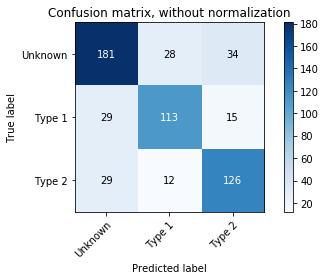

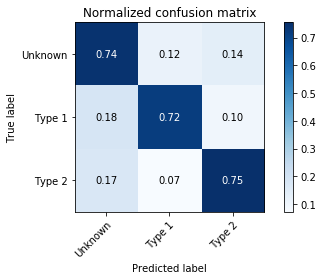

In [16]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print("Classes before:", classes)
    print("unique labels:", unique_labels(y_true, y_pred))
    classes = classes[unique_labels(y_true, y_pred)]
    print("Classes:", classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



np.set_printoptions(precision=2)

#class_names = np.array(["M", "F", "U"])
class_names = np.array(["Unknown", "Type 1", "Type 2"])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Predict having diabetes

In [23]:
trainingData.head()

,text,user_description,user_name,user_screen_name,HasDiabetes,Type_Diabetes,Sexe,History_HasDiab,History_TypeDiab,History_Sex,HaveDiab_merge,history_typeDiab_total
0,@Dmartelz24 @Dterrazas760 Then diabetes Kankle...,Account Manager for Dr.Pepper Snapple Group. D...,Jimmy Martinez,R8TERFAN1,0.0,0,M,NaN,NaN,NaN,0.0,0
1,"Woke up with a 30 blood sugar, hate half a can...",It's worth it.,Kelsey Smith,Kelsey_Smith88,1.0,1,U,NaN,NaN,M,1.0,1
2,I’m going back to my roots. I’m trying shakes ...,Life isn't about surviving the storms...it's a...,Lennie Ledesma,lennieledesma,1.0,0,U,NaN,NaN,M,1.0,0
3,Praying I don’t get diabetes,I'm still not fat I'm just short for my weight...,Regina George 💎,BlowindatPINK_,0.0,0,F,NaN,NaN,NaN,0.0,0
4,Happy world diabetes today💙💙 #t1dstrong https:...,I have a dead pancreas☹️ santiago🐬,riley:),itsRiMay,1.0,1,F,NaN,NaN,NaN,1.0,1


In [22]:
def preprocess_tweet(tweet):
    tweet = prep.replace_hashtags_URL_USER(tweet, mode_URL="replace", mode_Mentions="replace")
    tweet = prep.tokenize(tweet)
    return tweet


def create_haveDiab_column(row):
    if isinstance(row["History_HasDiab"], str): return row["HasDiabetes"]
    elif float(row["History_HasDiab"]) < 1e-9: return 0
    elif float(row["History_HasDiab"])-1 < 1e-9: return 1
    elif pd.isnull(row["History_HasDiab"]) : return row["HasDiabetes"]
    else: print("ERROR: Should not occur:  ", row["HasDiabetes"], ";;;", row["History_HasDiab"])

trainingData['HaveDiab_merge'] = trainingData.apply (lambda row: create_haveDiab_column(row), axis=1)

trainingData.HaveDiab_merge.value_counts()

0.0    1364
1.0     532
Name: HaveDiab_merge, dtype: int64

In [26]:
#label = "Type_Diabetes"
label = "history_typeDiab_total"
data_pd = trainingData[["text", "user_description", "user_name", label]]
data_pd.head()

data_pd["text_vec"] = data_pd.text.map(lambda tweet: tweet_vectorizer(preprocess_tweet(tweet), model_we))
data_pd["user_description_vec = data_pd.user_description.map(lambda userDesc: np.zeros((model_we.vector_size, )) 
                                                if isinstance(userDesc, float) or userDesc == " " 
                                                else tweet_vectorizer(preprocess_tweet(userDesc), model_we))

def userName_to_vec(name):
    #print("name:", name)
    try:
        firstName = unicodedata.normalize('NFKD', name).encode('ascii', 'ignore').decode('utf-8', 'ignore').split(" ")[0].replace(" ", "")
        vec = model_we[firstName]
    except:
        vec = np.zeros((model_we.vector_size, ))

    return vec

data_pd.user_name = data_pd.user_name.map(lambda name: userName_to_vec(name))

print(data_pd.columns)

# remove the tweets that are empty because there is no word embedding
data_pd = data_pd[data_pd["text_vec"].apply(lambda x: len(x)>0) ]
print(data_pd.shape)

#data_pd.user_name = data_pd.user_name.map(lambda tweet: prep.remove_non_ascii(tweet))
data_pd.head(10)


/Users/Adrian/miniconda3/envs/deepscience/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for 𝙸 !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embedding for " !!!!!!!!!!!!
no embed

/Users/Adrian/miniconda3/envs/deepscience/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/Users/Adrian/miniconda3/envs/deepscience/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


KeyError: 'text_vec'

In [ ]:
# choose algo:
#---------------------------------------------------------------------------
modelAlgo = "SVC"

if modelAlgo == "MultinomialNB":
    model = MultinomialNB(random_state=0)
elif modelAlgo == "SVC":
    model = SVC(random_state=0)
elif modelAlgo == "logReg":
    model = LogisticRegression(random_state=0)
elif modelAlgo == "RandomForest" :
    model = RandomForestClassifier(random_state=0)
elif modelAlgo == "XGBoost" :
    model = XGBClassifier(random_state=0)
elif modelAlgo == "MLP" :
    model = MLPClassifier(early_stopping=True, batch_size=32, random_state=0)

from imblearn.pipeline import Pipeline    
    
pipeline  = Pipeline([
                #("debuge", Debug("start")),
                ('union', FeatureUnion(
                            transformer_list = [
                                ('tweet', Pipeline([
                                    ('tweetsSelector', ItemSelect(key='text')),
                                    #("debugeq", Debug("text Selector")),
                                ])),  
                                ('userDesc', Pipeline([
                                    ('userDescSelector', ItemSelect(key='user_description'))
                                ])),
#                                ('userName', Pipeline([
#                                    ('userNameSelector', ItemSelect(key='user_name'))
#                                ]))     
                            ],
                )),
                #("debuggg", Debug("before model")),
                ('smote', SMOTE(random_state=12, sampling_strategy="auto", n_jobs=-1)), # , ratio = 1.0
                ('model', model),
                #("debuggg", Debug("after model")),
            ])


# parameter grid for grid search by using fastText embeddings
parameters = {
                'union__transformer_weights' : #[#{"tweet": 1, "userDesc":1, "userName":1},
#                                                {"tweet": 1, "userDesc":1, "userName":0.8}, 
#                                                {"tweet": 1, "userDesc":1, "userName":0.5},
#                                                {"tweet": 1, "userDesc":1, "userName":0.5},
#                                                {"tweet": 1, "userDesc":1, "userName":0.4},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.4},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0.8, "userName":0.6},
#                                                {"tweet": 1, "userDesc":0.7, "userName":0.5},
#                                                {"tweet": 1, "userDesc":0.9, "userName":0.5},
#                                                ],
                                               [#{"tweet": 1, "userDesc":1}, 
                                                {"tweet": 1, "userDesc":0.7}, 
                                                {"tweet": 1, "userDesc":0.5},
                                                {"tweet": 1, "userDesc":0.3},
#                                                {"tweet": 1, "userDesc":0.1},
#                                                {"tweet": 1, "userDesc":0.0},
#                                                {"tweet": 0, "userDesc":1}
                                                ],
    
               'smote__k_neighbors' : [2, 3, 4, 5],

#               # param for SVC
               'model__kernel' : ["linear"],#["linear", "poly", "rbf"],
               'model__C' : [0.5, 0.1, 0.01],
               'model__tol' : [1e-1, 1e-2, 1e-3],
#               'model__class_weight' : ["balanced", {0:1, 1:1, 2:1}, {0:1, 1:2, 2:1}, {0:1, 1:1, 2:2}, {0:1, 1:2, 2:2}],
#
#               # param for RandomForestClassifier
#               'model__n_estimators' : [50, 100, 150],
#               'model__criterion' : ['gini', 'entropy'],
#               'model__max_features' : ['auto', 'log2'],
#               'model__max_depth' : [ 5, 10, 20, 30]
#
#               # param for XGBoost Best: 0.910828 using {'model__learning_rate': 0.05, 'model__reg_alpha': 0, 'model__max_depth': 3, 'model__reg_lambda': 1.5, 'model__n_estimators': 300}
#               'model__max_depth' : [3,4],
#               'model__learning_rate' : [0.5, 0.1, 0.05],#, 0.01, 0.001],
#               'model__booster' : ["gblinear"], #["gbtree", "gblinear", "dart"],
#               'model__gamma' : [0, 0.01],
#               'model__n_estimators' : [80, 100, 150],
#               'model__reg_alpha' : [0, 0.1],
#               'model__reg_lambda' : [0.5, 1.0]
}
